# Вторая домашняя работа по нейронным сетям

Необходимо классифицировать людей на фото из датасета: [Датасет](https://susanqq.github.io/UTKFace/) по полу и расе, а также определить возраст. Мы будем использовать в качестве базовой модель VGGFace2
Модель VGGFace2 натренирована работать с лицами, и есть вероятность, что признаки, которые она извлекает могут быть использованы для классификации не только лиц по людям, но и лиц по полам, возрастам и рассам. Хотя достаточно очевидно, что это не совсем так, потому что, например, какой-то человек-мужчина, про которого известно, как его зовут, может быть очень сильно похож на женщину, и наоборот.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import gdown
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from livelossplot.tf_keras import PlotLossesCallback
from collections import Counter
import graphviz
import pydot
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.5.0


## Загрузка предобученной модели

In [2]:
if not Path('resnet50face.h5').exists():
    url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
    output = 'resnet50face.h5'
    gdown.download(url, output, quiet=False)
vggface_model = load_model('resnet50face.h5')

In [3]:
if not Path('brad_pitt.jpg').exists():
    os.system('wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg')

In [4]:
# Препроцессинг и декодирование результата
def vgg_preprocess(x):
    x_temp = x.copy()
    x_temp = x_temp[..., ::-1]
    x_temp[..., 0] -= 91.4953
    x_temp[..., 1] -= 103.8827
    x_temp[..., 2] -= 131.0912
    return x_temp

def vgg_decode(preds, top=5):
    LABELS = None
    if len(preds.shape) == 2:
        if preds.shape[1] == 2622:
            LABELS = np.load('rcmalli_vggface_labels_v1.npy')
        elif preds.shape[1] == 8631:
            LABELS = np.load('rcmalli_vggface_labels_v2.npy')
        else:
            raise ValueError('`decode_predictions` expects '
                             'a batch of predictions '
                             '(i.e. a 2D array of shape (samples, 2622)) for V1 or '
                             '(samples, 8631) for V2.'
                             'Found array with shape: ' + str(preds.shape))
    else:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 2622)) for V1 or '
                         '(samples, 8631) for V2.'
                         'Found array with shape: ' + str(preds.shape))
    
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [[str(LABELS[i].encode('utf8')), pred[i]] for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results
# Это файлы с декодирующими словарями
if not Path('rcmalli_vggface_labels_v1.npy').exists():
    os.system('wget https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v1.npy')
if not Path('rcmalli_vggface_labels_v2.npy').exists():
    os.system('wget https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy')

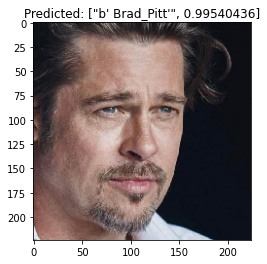

In [5]:
# Тестируем работу модели на случаном фото. Ага, случайное)) Тут кто-то, кажется, фанатеет от Бреда Питта
img = image.load_img("brad_pitt.jpg", target_size=(224, 224))
x = vgg_preprocess(image.img_to_array(img))
x = np.expand_dims(x, axis=0)
preds = vggface_model.predict(x)
brad_pit_idx = np.argmax(preds)
plt.title(f"Predicted: {vgg_decode(preds)[0][0]}") 
plt.imshow(img)

## Загрузка датасета

In [6]:
if not Path('/tmp/UTKFace.tar.gz').exists():
    url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
    output = '/tmp/UTKFace.tar.gz'
    gdown.download(url, output, quiet=False)
    os.system('tar -xzf /tmp/UTKFace.tar.gz -C /tmp/')
    url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
    output = 'train_val_split_utk.csv'
    gdown.download(url, output, quiet=False)

In [7]:
# формируем датафрейм с путями и нужными классами
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg


,img_name,age,race,gender
0,26_1_3_20170117153146187.jpg.chip.jpg,0.224138,3,1
1,8_1_0_20170109205015327.jpg.chip.jpg,0.068966,0,1
2,38_1_0_20170104201618841.jpg.chip.jpg,0.327586,0,1
3,2_0_2_20161219190009084.jpg.chip.jpg,0.017241,2,0
4,26_1_0_20170117174948312.jpg.chip.jpg,0.224138,0,1


In [8]:
# Разбиваем на тренировочную и валидационную выборки
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


## Создание генератора данных для модели предсказания пола

In [9]:
image_gen = ImageDataGenerator(preprocessing_function=vgg_preprocess)
BATCH_SIZE = 128
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(
    df_train,
    directory=str(data_folder),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    x_col='img_name',
    y_col='gender')

val_generator = image_gen.flow_from_dataframe(
    df_val,
    directory=str(data_folder),
    shuffle=False,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    x_col='img_name',
    y_col='gender')

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [10]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Female


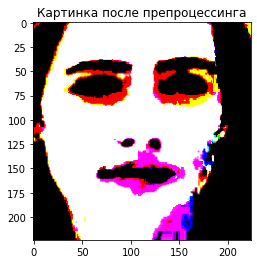

In [11]:
plt.imshow(sample_images[100])
plt.title('Картинка после препроцессинга')
print(gender_mapping[int(sample_labels[100])])

Male


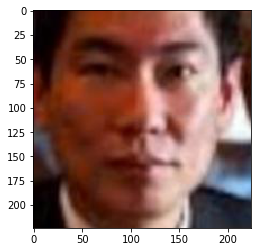

In [12]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    # < YOUR CODE STARTS HERE >
    image = vggface_image.copy()
    image = image[..., ::-1]
    image[..., 2] += 91.4953
    image[..., 1] += 103.8827
    image[..., 0] += 131.0912

    
    # < YOUR CODE ENDS HERE >
    return image.astype(np.uint8)

# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])])

In [13]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model(vggface_model.input, vggface_model.get_layer("flatten_1").output)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [14]:
# Загрузка модели с гугл диска
MODEL_GOOGLE_DOWNLOAD = True # Включение/выключение загрузки модели с диска
if MODEL_GOOGLE_DOWNLOAD and not Path("model_gender/checkpoint_best.h5").exists():
    Path('model_gender').mkdir(exist_ok=True)
    url = 'https://drive.google.com/u/0/uc?id=1sgFAjxI_o1lMcg-vTzghBmOCddcRF7OG&export=download'
    output = "model_gender/checkpoint_best.h5"
    gdown.download(url=url, output=output)

In [15]:
# Содание/загрузка модели
if Path("model_gender/checkpoint_best.h5").exists():
    model_gender = load_model("model_gender/checkpoint_best.h5")
else:
    # Замораживаем базовую модель
    base_model.trainable = True
    for layer in base_model.layers[:-6]:
        layer.trainable = False
    model_gender = tf.keras.Sequential([base_model, tf.keras.layers.Dense(1, activation="sigmoid")])
model_gender.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_7 (Functional)         (None, 2048)              23561152  
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 1,054,721
Non-trainable params: 22,508,480
_________________________________________________________________


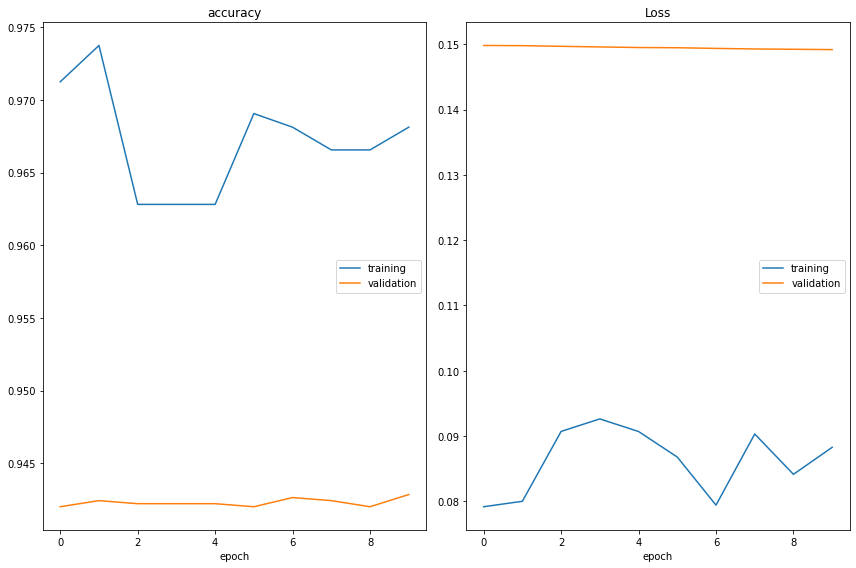

accuracy
	training         	 (min:    0.963, max:    0.974, cur:    0.968)
	validation       	 (min:    0.942, max:    0.943, cur:    0.943)
Loss
	training         	 (min:    0.079, max:    0.093, cur:    0.088)
	validation       	 (min:    0.149, max:    0.150, cur:    0.149)


In [16]:
# Обучение на распознавание полов
# Ячейку можно не включать: модель уже обучена
learning_rate = 0.00001
model_gender.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
EPOCHS = 10
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_gender/checkpoint_best.h5",
    save_best_only=True)
history = model_gender.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint])

In [17]:
model_gender = load_model("model_gender/checkpoint_best.h5")
loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 12s 298ms/step - loss: 0.1492 - accuracy: 0.9428
Well done!


In [18]:
#@title (вспомогательный код, выполните клетку)
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]).astype(np.uint8))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

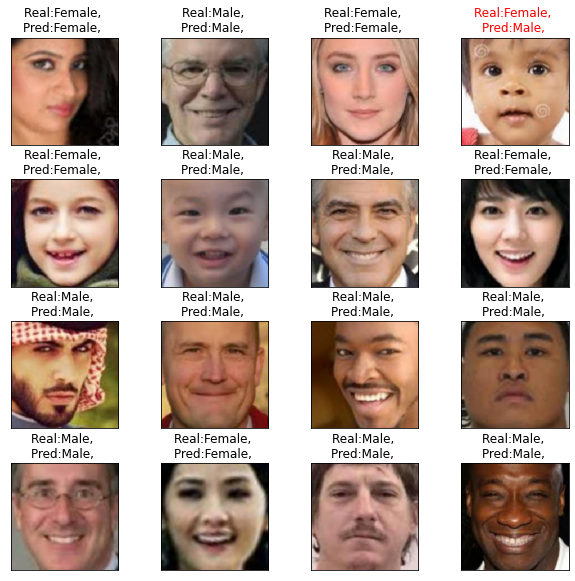

In [19]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

# Обучение модели предсказания расы

In [20]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)

In [21]:
train_generator = image_gen.flow_from_dataframe(
    df_train,
    directory=str(data_folder),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    x_col='img_name',
    y_col='race')

val_generator = image_gen.flow_from_dataframe(
    df_val,
    directory=str(data_folder),
    shuffle=False,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    x_col='img_name',
    y_col='race')

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [22]:
# Загрузка модели с гугл диска
if MODEL_GOOGLE_DOWNLOAD and not Path("model_race/checkpoint_best.h5").exists():
    Path('model_race').mkdir(exist_ok=True)
    url = 'https://drive.google.com/u/0/uc?id=14Qt1aDhysJoaMJO_YsAvefUhEHPBt3uI&export=download'
    output = "model_race/checkpoint_best.h5"
    gdown.download(url=url, output=output)

In [23]:
# Содание/загрузка модели
if Path("model_race/checkpoint_best.h5").exists():
    model_race = load_model("model_race/checkpoint_best.h5")
else:
    # Замораживаем базовую модель
    base_model.trainable = False
    model_race = tf.keras.Sequential([base_model, tf.keras.layers.Dense(5, activation="softmax")])
model_race.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2048)              23561152  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 23,571,397
Trainable params: 10,245
Non-trainable params: 23,561,152
_________________________________________________________________


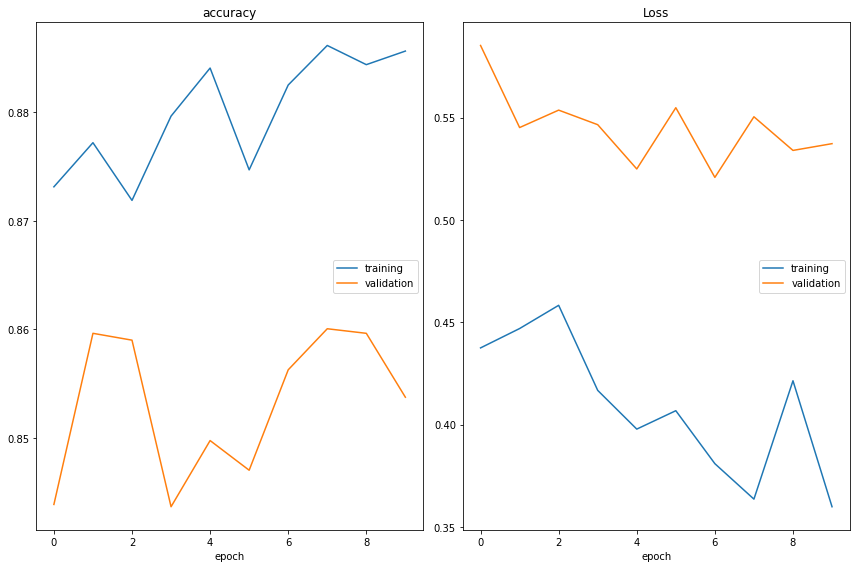

accuracy
	training         	 (min:    0.872, max:    0.886, cur:    0.886)
	validation       	 (min:    0.844, max:    0.860, cur:    0.854)
Loss
	training         	 (min:    0.360, max:    0.458, cur:    0.360)
	validation       	 (min:    0.521, max:    0.585, cur:    0.537)


In [24]:
# Обучение на распознавание рассы
# Ячейку можно не выполнять
learning_rate = 0.001
model_race.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
EPOCHS = 10
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_race/checkpoint_best.h5",
    save_best_only=True)
history = model_race.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(), checkpoint])

In [25]:
model_race = load_model("model_race/checkpoint_best.h5")
loss, acc = model_race.evaluate(val_generator)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 12s 294ms/step - loss: 0.5208 - accuracy: 0.8563
Well done!


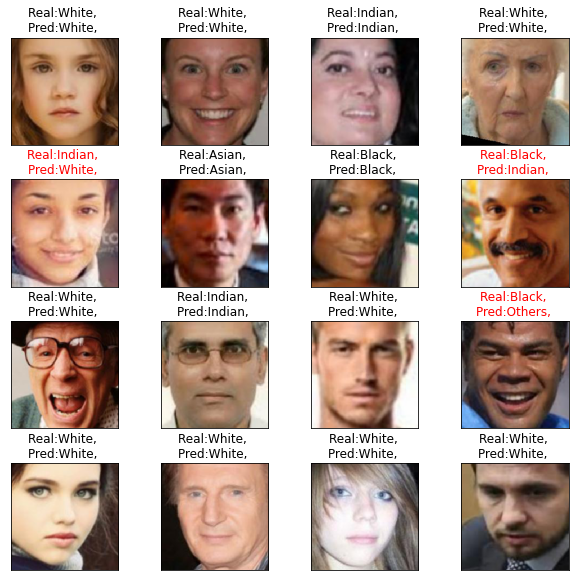

In [26]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

# Multitask learning

In [27]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

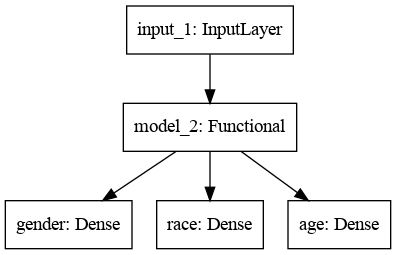

In [28]:
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
output_gender = tf.keras.layers.Dense(1, activation="sigmoid", name="gender")(base_model(input_layer))
output_race = tf.keras.layers.Dense(5, activation="softmax", name="race")(base_model(input_layer))
output_age = tf.keras.layers.Dense(1, activation="sigmoid", name="age")(base_model(input_layer))
model = tf.keras.Model(inputs=input_layer, outputs=[output_gender, output_race, output_age])
tf.keras.utils.plot_model(model)

In [29]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


In [30]:
df_train[["age", "race", "gender"]] = df_train[["age", "race", "gender"]].astype(np.float32)
df_val[["age", "race", "gender"]] = df_val[["age", "race", "gender"]].astype(np.float32)
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="multi_output",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="multi_output",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    """
    Вспомогательная функция, которая преобразует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1], 3, axis=1)
        yield image, {"gender" : labels[0], "race" : labels[1], "age" : labels[2]}

Found 18946 validated image filenames.
Found 4759 validated image filenames.


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [31]:
# Загрузка модели с гугл диска
if MODEL_GOOGLE_DOWNLOAD and not Path("model_multitask/checkpoint_best.h5").exists():
    Path('model_multitask').mkdir(exist_ok=True)
    url = 'https://drive.google.com/u/0/uc?id=1YmcmMsl7vTFrD6v355R7SfcxFH9T6K1S&export=download'
    output = "model_multitask/checkpoint_best.h5"
    gdown.download(url=url, output=output)

In [34]:
# Содание/загрузка модели
if Path("model_multitask/checkpoint_best.h5").exists():
    model = load_model("model_multitask/checkpoint_best.h5")

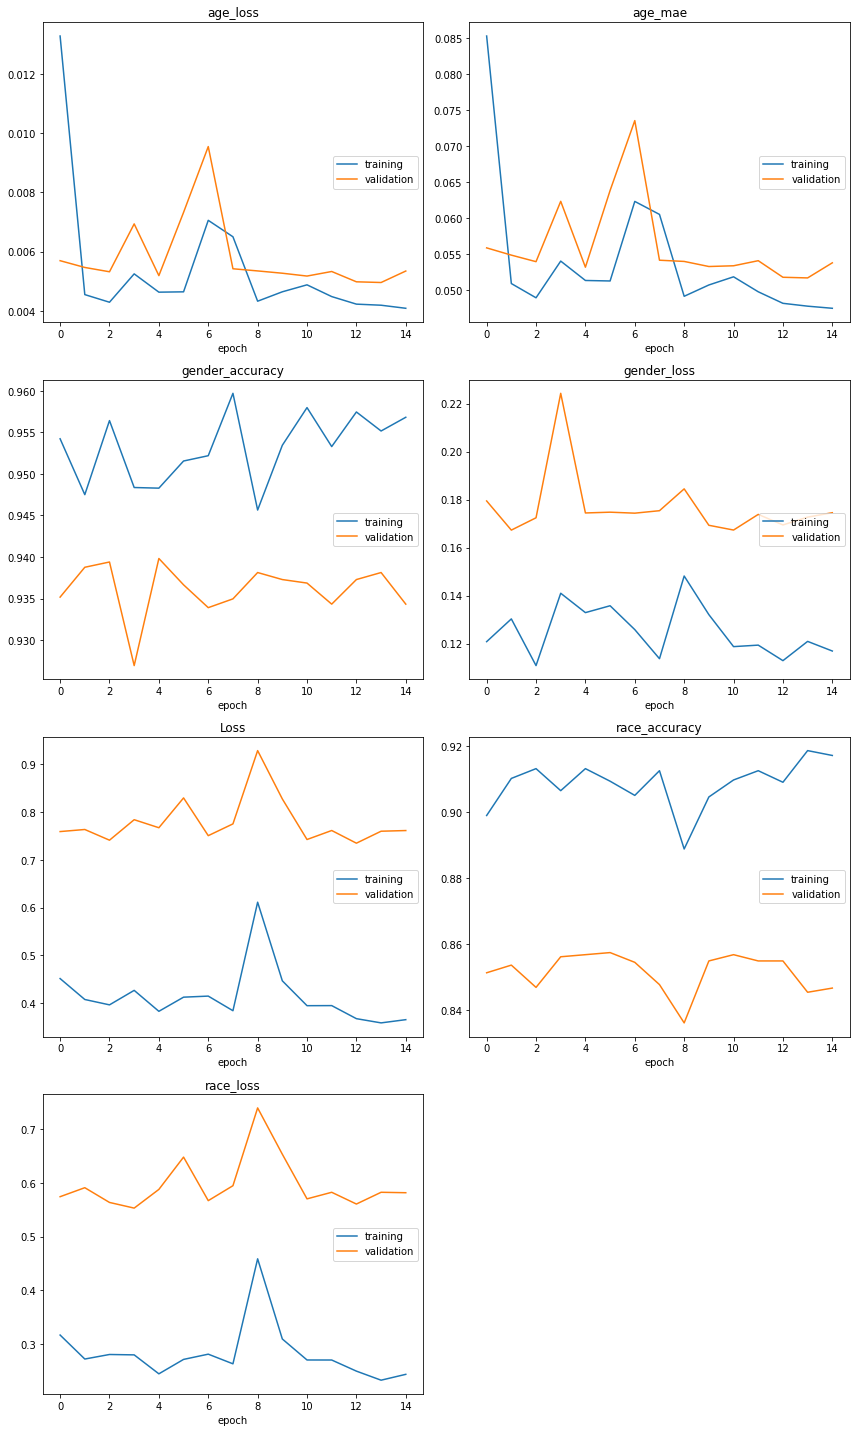

age_loss
	training         	 (min:    0.004, max:    0.013, cur:    0.004)
	validation       	 (min:    0.005, max:    0.010, cur:    0.005)
age_mae
	training         	 (min:    0.047, max:    0.085, cur:    0.047)
	validation       	 (min:    0.052, max:    0.074, cur:    0.054)
gender_accuracy
	training         	 (min:    0.946, max:    0.960, cur:    0.957)
	validation       	 (min:    0.927, max:    0.940, cur:    0.934)
gender_loss
	training         	 (min:    0.111, max:    0.148, cur:    0.117)
	validation       	 (min:    0.167, max:    0.224, cur:    0.175)
Loss
	training         	 (min:    0.358, max:    0.611, cur:    0.365)
	validation       	 (min:    0.735, max:    0.929, cur:    0.761)
race_accuracy
	training         	 (min:    0.889, max:    0.919, cur:    0.917)
	validation       	 (min:    0.836, max:    0.857, cur:    0.847)
race_loss
	training         	 (min:    0.233, max:    0.459, cur:    0.244)
	validation       	 (min:    0.553, max:    0.739, cur:    0.581)

E

In [35]:
# Эту ячейку тоже можно пропустить (модель обучена)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # вы можете выбрать другую скорость обучения для вашей модели

# обратите внимание, что теперь loss -- это словарьи, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics
model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='age_mae', verbose=1, save_best_only=True, mode='min')

model.fit(train_generator, epochs=15, validation_data=val_generator,
                    callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=50, 
                    validation_steps= len(df_val) // BATCH_SIZE)

In [36]:
model_multitask = load_model("model_multitask/checkpoint_best.h5")
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="multi_output",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
results = model_multitask.evaluate(val_generator, steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

Found 4759 validated image filenames.
37/37 [==============================] - 33s 855ms/step - loss: 0.7651 - gender_loss: 0.1750 - race_loss: 0.5848 - age_loss: 0.0053 - gender_gender_accuracy: 0.9341 - race_race_accuracy: 0.8463 - age_age_mae: 0.0538
Well done!


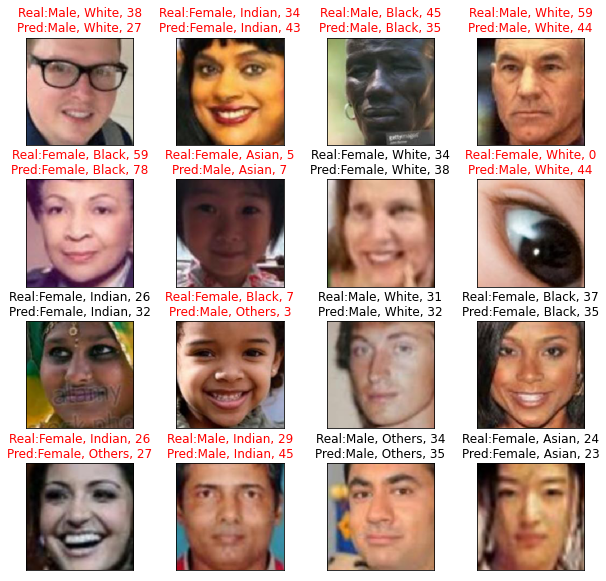

In [37]:
# Проверяем работу модели
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten())

Загружаем любое лицо из сети и получаем результат

Downloading...
From: https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-
To: /home/alex/Downloads/skillbox/homework_nn_2/not_me.jpg
2.34MB [00:04, 544kB/s]


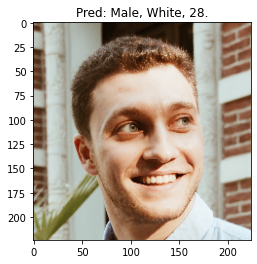

In [38]:
url = 'https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-'
output = 'not_me.jpg'
gdown.download(url, output, quiet=False)

img = image.load_img("not_me.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg_preprocess(x) 
predicted_labels = model_multitask.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)
# Не-я получился немного моложе :) Интересно, на сколько?

# Выводы
1. Задания выполнены
2. Тесты пройдены
3. Результаты получены
4. Можно было бы просто объединить уже обученные сети для распознования рассы и пола с отдельно обученной сетью для определения возраста. Это было бы быстрее и проще, а главное: можно было бы достигнуть большей точности, так как все модели обучаются с разными скоростями, но мы не ищем легких путей!!!